In [1]:
from utilities.setup_environment import *
from utilities.utilities import *
from utilities.plotting import *
from utilities.getStim import *
pd.set_option('display.max_columns', None)

import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_context("poster")
from scipy.stats import sem
import os

In [2]:
cell_type = 'OFF transient alpha' # ['OFF transient alpha' 'ON alpha' 'OFF sustained alpha']
cell_text = True # prints cellname next to the plot
frame_rate = 60


In [3]:


cell_type_str = re.sub(r'\W+', '_', cell_type.strip())
df_celltype = pd.read_csv(f'results/{cell_type_str}_PSD_gain.csv')
df_celltype = convert_stringified_arrays(df_celltype)

Converted the following columns to NumPy arrays:
  - freq
  - stim_psd
  - rs_spikes_psd
  - nr_spikes_psd
  - H_f_power_rs
  - H_f_power_nr
  - stim_autocorr
  - spikes_autocorr_rs
  - spikes_autocorr_nr


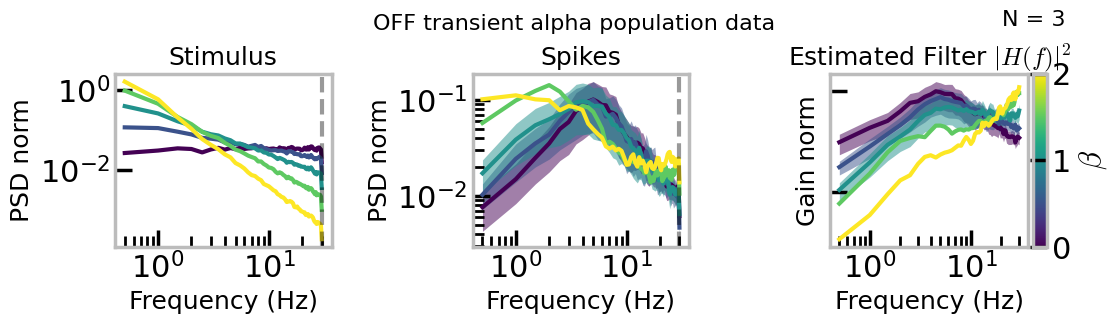

In [4]:
n_cells = df_celltype['cell_name'].nunique()
beta_values = sorted(df_celltype['beta'].unique())
norm = mcolors.Normalize(vmin=min(beta_values), vmax=max(beta_values))

cmap = plt.get_cmap('viridis')
label_fontsize = 18
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
fig.suptitle(f"{cell_type} population data", fontsize=16, y=.84)
fig.text(0.91, 0.85, f"N = {n_cells}", ha='right', va='top', fontsize=16)

for beta_value in (beta_values):
    color = cmap(norm(beta_value))
    data_beta = df_celltype[df_celltype['beta'] == beta_value]
    
    freqs = df_celltype[df_celltype['beta'] == beta_value]['freq'].iloc[0]
    stim_psd = df_celltype[df_celltype['beta'] == beta_value]['stim_psd'].iloc[0]
    
    nr_psd_stack = np.stack(data_beta['nr_spikes_psd'].values)
    gain_stack = np.stack(data_beta['H_f_power_nr'].values)

    # Compute mean & SEM (excluding DC)
    mean_nr_spikes_psd = np.mean(nr_psd_stack[:, :], axis=0)
    sem_nr_spikes_psd = np.std(nr_psd_stack[:, :], axis=0) / np.sqrt(n_cells)

    mean_gain = np.mean(gain_stack[:, :], axis=0)
    sem_gain = np.std(gain_stack[:, :], axis=0) / np.sqrt(n_cells)
    norm_factor_g = np.trapz(mean_gain, freqs)
    mean_gain /= norm_factor_g
    sem_gain /= norm_factor_g

    # Normalize mean spike PSD and SEM
    norm_factor = np.trapz(mean_nr_spikes_psd, freqs)
    mean_nr_spikes_psd /= norm_factor
    sem_nr_spikes_psd /= norm_factor
    
    axes[0].loglog(freqs, stim_psd / np.trapz(stim_psd, freqs), c=color)

    axes[1].loglog(freqs, mean_nr_spikes_psd, label=fr"$\mathrm{{Mean}} \pm \mathrm{{s.e.m.}}$", color=color)
    axes[1].fill_between(freqs, 
                         mean_nr_spikes_psd - sem_nr_spikes_psd,
                         mean_nr_spikes_psd + sem_nr_spikes_psd,
                         color=color, alpha=0.5, linewidth=0)

    axes[2].loglog(freqs, mean_gain, color=color)
    axes[2].fill_between(freqs, 
                         mean_gain - sem_gain,
                         mean_gain + sem_gain,
                         color=color, alpha=0.5, linewidth=0)
axes[2].set_yticklabels([])

titles = ["Stimulus", "Spikes", r"Estimated Filter $|H(f)|^2$"]
ylabels = ["PSD norm", "PSD norm", "Gain norm"]
fig.patch.set_facecolor('white')     
for i, ax in enumerate(axes):
    ax.set_facecolor('white')  
    ax.set_title(titles[i], fontsize=label_fontsize)
    ax.set_xlabel("Frequency (Hz)", fontsize=label_fontsize)
    ax.set_ylabel(ylabels[i], fontsize=label_fontsize)
    if i != 2:
        ax.axvline(frame_rate / 2, color='k', alpha=0.4, linestyle='--')
    ax.grid(visible=False)
    # ax.set_ylim(psd_ylim if i != 2 else gain_ylim)

# Colorbar for beta
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="7%", pad=0.05)
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label(r'$\beta$', fontsize=22)

plt.tight_layout()

plt.show()

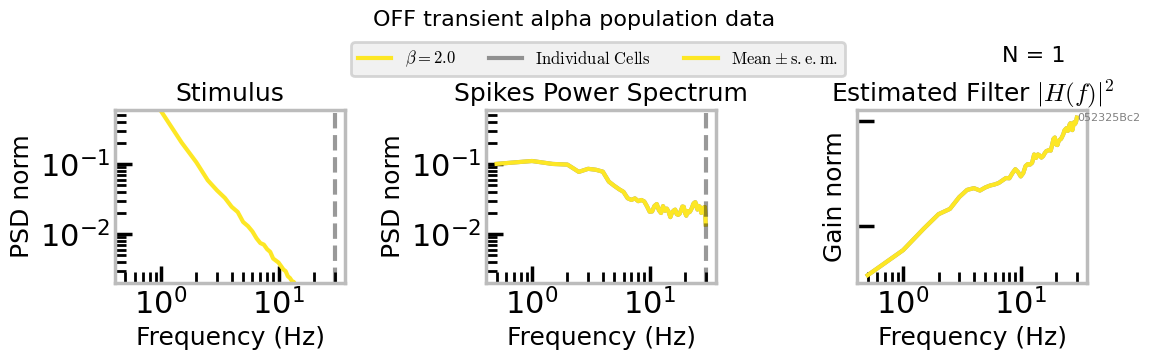

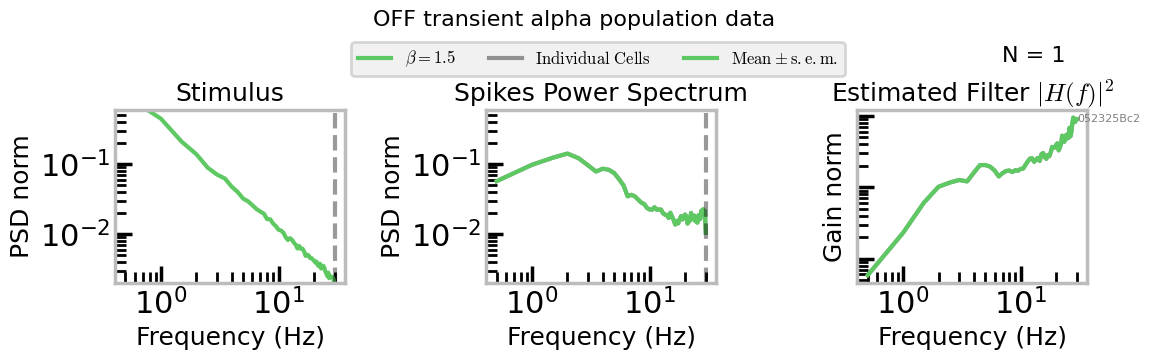

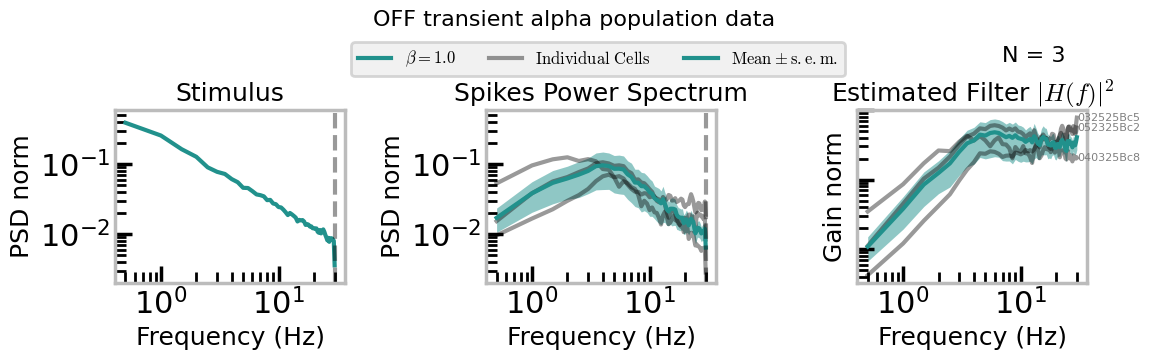

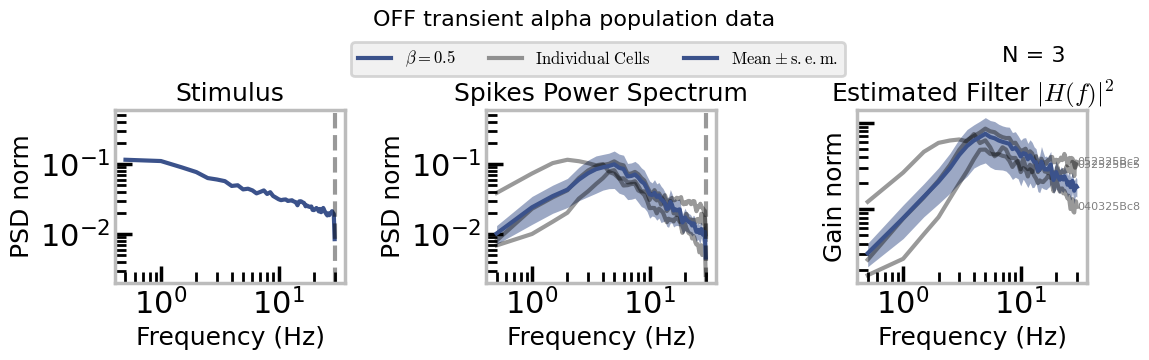

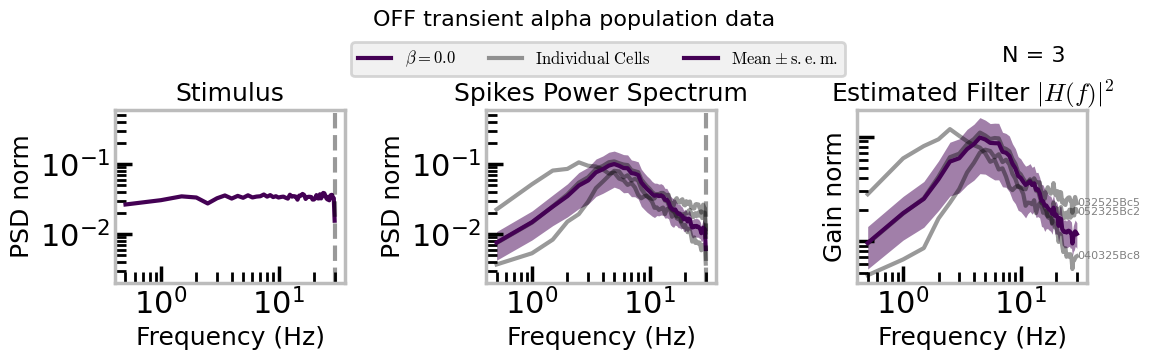

In [9]:
# Precompute global y-axis limits
all_nr_psd = []
all_gain = []

for beta_value in df_celltype['beta'].unique():
    data_beta = df_celltype[df_celltype['beta'] == beta_value]
    nr_psd_stack = np.stack(data_beta['nr_spikes_psd'].values)[:,:]
    gain_stack = np.stack(data_beta['H_f_power_nr'].values)[:,:]

    all_nr_psd.append(nr_psd_stack)
    all_gain.append(gain_stack)

all_nr_psd = np.concatenate(all_nr_psd, axis=0)
all_gain = np.concatenate(all_gain, axis=0)

# Normalize PSDs
norm_factors = np.trapz(all_nr_psd, axis=1)
norm_nr_psd = all_nr_psd / norm_factors[:, None]

min_psd = np.min(norm_nr_psd[norm_nr_psd > 0])
max_psd = np.max(norm_nr_psd)
min_gain = np.min(all_gain[all_gain > 0])
max_gain = np.max(all_gain)

psd_pad = (np.log10(max_psd) - np.log10(min_psd)) * 0.05
gain_pad = (np.log10(max_gain) - np.log10(min_gain)) * 0.05
if max_psd < 1:
    max_psd = 1

if min_psd < 1e-3:
    min_psd = 1e-3
psd_ylim = (10**(np.log10(min_psd) - psd_pad),0**(np.log10(max_psd) + psd_pad))
gain_ylim = (10**(np.log10(min_gain) - gain_pad),0**(np.log10(max_gain) + gain_pad))

beta_values = sorted(df_celltype['beta'].unique())
norm = mcolors.Normalize(vmin=min(beta_values), vmax=max(beta_values))
cmap = plt.get_cmap('viridis')
label_fontsize = 18
for beta_value in reversed(beta_values):
    color = cmap(norm(beta_value))
    data_beta = df_celltype[df_celltype['beta'] == beta_value]
    n_cells = data_beta['cell_name'].nunique()
    freqs = df_celltype[df_celltype['beta'] == beta_value]['freq'].iloc[0]
    stim_psd = df_celltype[df_celltype['beta'] == beta_value]['stim_psd'].iloc[0]
    
    nr_psd_stack = np.stack(data_beta['nr_spikes_psd'].values)
    gain_stack = np.stack(data_beta['H_f_power_nr'].values)

    # Compute mean & SEM (excluding DC)
    mean_nr_spikes_psd = np.mean(nr_psd_stack[:,:], axis=0)
    sem_nr_spikes_psd = np.std(nr_psd_stack[:,:], axis=0) / np.sqrt(n_cells)

    mean_gain = np.mean(gain_stack[:,:], axis=0)
    sem_gain = np.std(gain_stack[:,:], axis=0) / np.sqrt(n_cells)
    norm_factor_g = np.trapz(mean_gain, freqs)
    mean_gain /= norm_factor_g
    sem_gain /= norm_factor_g

    # Normalize mean spike PSD and SEM
    norm_factor = np.trapz(mean_nr_spikes_psd, freqs)
    mean_nr_spikes_psd /= norm_factor
    sem_nr_spikes_psd /= norm_factor
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
    fig.suptitle(f"{cell_type} population data", fontsize=16, y=.94)
    fig.text(0.91, 0.85, f"N = {n_cells}", ha='right', va='top', fontsize=16)

    for i, cell_name in enumerate(data_beta['cell_name'].unique()):
        label_cell = r'$\mathrm{Individual \ Cells}$' if i == 0 else None
        row = data_beta[data_beta['cell_name'] == cell_name].iloc[0]
        nr_spikes_psd = row['nr_spikes_psd']
        H_f_power_nr = row['H_f_power_nr']

    
        axes[1].loglog(freqs, nr_spikes_psd / np.trapz(nr_spikes_psd, freqs),
                    alpha=0.4, c='k', label=label_cell)

    
        axes[2].loglog(freqs, H_f_power_nr/np.trapz(H_f_power_nr, freqs), alpha=0.4, c='k')
        if cell_text:
            axes[2].text(freqs[-1], H_f_power_nr[-1]/np.trapz(H_f_power_nr, freqs), cell_name, fontsize=8, color='gray', ha='left', va='center')
    axes[0].loglog(freqs, stim_psd / np.trapz(stim_psd, freqs),
                   label=fr"$\beta={beta_value}$", c=color)

    axes[1].loglog(freqs, mean_nr_spikes_psd, label=fr"$\mathrm{{Mean}} \pm \mathrm{{s.e.m.}}$", color=color)
    axes[1].fill_between(freqs, 
                         mean_nr_spikes_psd - sem_nr_spikes_psd,
                         mean_nr_spikes_psd + sem_nr_spikes_psd,
                         color=color, alpha=0.5, linewidth=0)

    axes[2].loglog(freqs, mean_gain, label=fr"$\beta={beta_value}$", color=color)
    axes[2].fill_between(freqs, 
                         mean_gain - sem_gain,
                         mean_gain + sem_gain,
                         color=color, alpha=0.5, linewidth=0)
    axes[2].set_yticklabels([])

    titles = ["Stimulus", "Spikes Power Spectrum", r"Estimated Filter $|H(f)|^2$"]
    ylabels = ["PSD norm", "PSD norm", "Gain norm"]
    fig.patch.set_facecolor('white')     
    for i, ax in enumerate(axes):
        ax.set_facecolor('white')  
        ax.set_title(titles[i], fontsize=label_fontsize)
        ax.set_xlabel("Frequency (Hz)", fontsize=label_fontsize)
        ax.set_ylabel(ylabels[i], fontsize=label_fontsize)
        
        if i != 2:
            ax.axvline(frame_rate / 2, color='k', alpha=0.4, linestyle='--')
            ax.set_ylim(2e-3, .6)
            
        ax.grid(visible=False)


    handles0, labels0 = axes[0].get_legend_handles_labels()
    handles1, labels1 = axes[1].get_legend_handles_labels()
    unique_labels = dict(zip(labels0 + labels1, handles0 + handles1))
    fig.legend(unique_labels.values(), unique_labels.keys(),
               loc='upper center', bbox_to_anchor=(0.52, 0.88), ncol=4, fontsize=12)

    plt.tight_layout()
    plt.show()